In [1]:
import glob
import os
import pathlib
import pickle
import sys
import warnings

import IPython.display as ipd
import ipywidgets as widgets
import librosa
import librosa.core
import librosa.display
import librosa.feature
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import scipy
import yaml
from ipywidgets import interact, interact_manual
from keras.layers import Dense, Input
from keras.models import Model
from pyod.models.gmm import GMM
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.utils.data import evaluate_print, generate_data
from pyod.utils.example import visualize
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# from import
from tqdm import tqdm

import preprocess as preproc


########################################################################


########################################################################
# import additional python-library
########################################################################


warnings.filterwarnings("ignore")

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [2]:
from numba import cuda


torch.cuda.empty_cache()
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x00000288B41B92C0 to Device at 0x00000288B403C130>

In [3]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Audio examples loading and plot 

## MIMII DUE dataset

In [4]:
normal_example = r"datasets\MIMII_DUE\dev_data\gearbox\source_test\section_00_source_test_normal_0002.wav"
anomal_example = r"datasets\MIMII_DUE\dev_data\gearbox\source_test\section_00_source_test_anomaly_0002.wav"

In [5]:
ipd.Audio(normal_example)

In [6]:
ipd.Audio(anomal_example)

In [8]:
def wav_plot(audio_file, name="wav_plot"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    x, sr = librosa.load(audio_file, sr=16000, mono=True)
    librosa.display.waveshow(x, sr=sr, ax=ax1)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.title(name)
    librosa.display.specshow(Xdb, sr=sr, x_axis="time", y_axis="hz", ax=ax2)
    plt.title(f"{name}_spectrogram")
    plt.show()

In [9]:
# Normal & anomaly examples, amplitude, spectrogram plots
fdir = "datasets\MIMII_DUE\dev_data\gearbox\source_test/"


@interact
def show_images(file=os.listdir(fdir)):
    wav_plot(fdir + file)

interactive(children=(Dropdown(description='file', options=('section_00_source_test_anomaly_0000.wav', 'sectio…

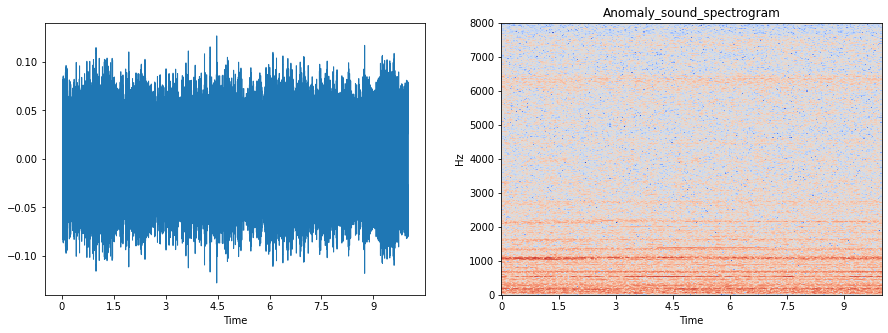

In [10]:
# Anomaly gearbox sound example
wav_plot(anomal_example, "Anomaly_sound")

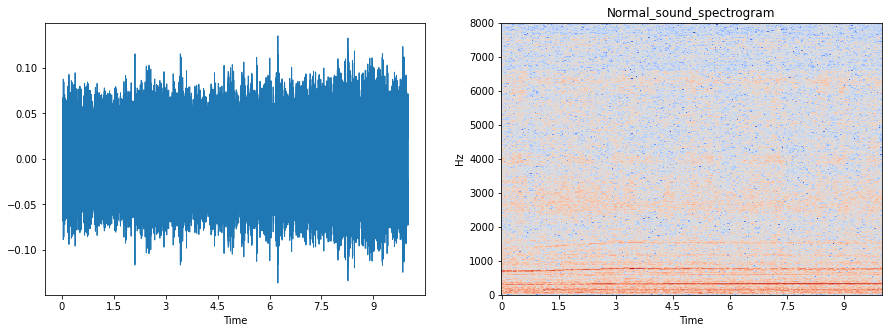

In [11]:
# Normal gearbox sound example
wav_plot(normal_example, "Normal_sound")

## ToyAdmos Dataset

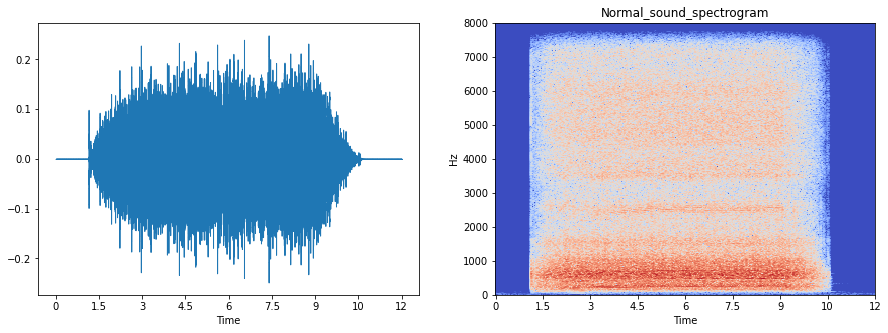

In [12]:
# Normal example
normal_example_ToyAdm = (
    r"datasets\ToyAdmos2\toyad2_car_A1_normal/CN001-carA1-speed1_mic1_00001.mp4"
)
wav_plot(normal_example_ToyAdm, "Normal_sound")

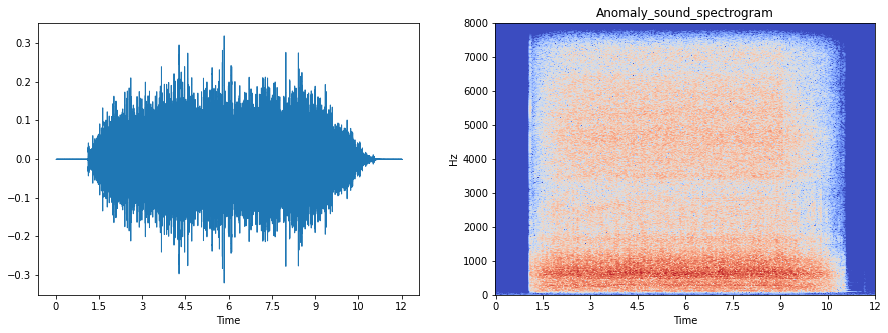

In [13]:
# Anomaly example
anomaly_example_ToyAdm = (
    r"datasets\ToyAdmos2\toyad2_car_A_anomaly/CA001-carA1-speed1-a-damageL_mic1_00001.mp4"
)
wav_plot(anomaly_example_ToyAdm, "Anomaly_sound")

## MFCC Extraction from audio using Librosa

Получение MFCC коэффициентов:
1. сигнал делится на пересекающиеся отрезки по 20-40 мс
2. На этих отрезках применяется оконное реобразование Фурье (STFT)
3. С посмощью применения различных фильтров и преобразований остаются только частоты, ваосринимаемые человеческим ухом 20-20000Гц (Мощность сектра после STFT наносится на mel шкалу с помощью теругольных или косинусных перекрывающих окон) 
4. В итоге MFCC - это амплитуды результирующего спектра


In [14]:
def plot_MFFC_from_audio(file_name, n_mfcc):
    x, sr = librosa.load(file_name, sr=16000, mono=True)
    mfccs = librosa.feature.mfcc(x, sr=sr, n_mfcc=n_mfcc)
    plt.figure(figsize=(7, 4))
    plt.title("MFCC")
    librosa.display.specshow(mfccs, sr=sr, x_axis="time")

In [15]:
fdir = "datasets\MIMII_DUE\dev_data\gearbox\source_test/"
# Interact with specification of arguments


@interact
def show_articles_more_than(file=os.listdir(fdir), x=(2, 100)):
    return plot_MFFC_from_audio(fdir + file, x)

interactive(children=(Dropdown(description='file', options=('section_00_source_test_anomaly_0000.wav', 'sectio…

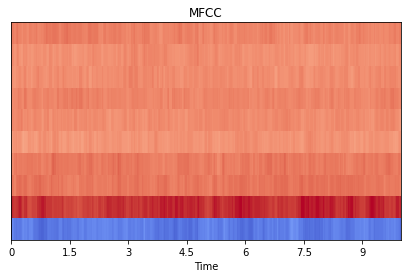

In [16]:
# MIMII_DUE normal sound
plot_MFFC_from_audio(normal_example, 10)

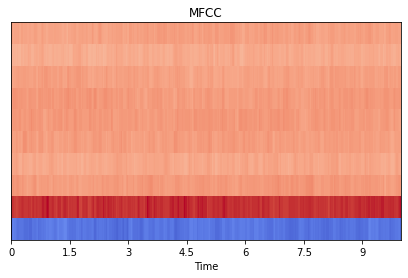

In [17]:
# MIMII_DUE anomaly sound
plot_MFFC_from_audio(anomal_example, 10)

# Dataset creation

## MIMII_DUE

In [18]:
# train data dir
target_dir_train = r"datasets\MIMII_DUE\dev_data\gearbox"
section_name = "section_00"
dir_name_train = r"\train"
mode = "development"

# target_test data dir
target_dir_test = r"datasets\MIMII_DUE\dev_data\gearbox"
dir_name_target_test = r"\target_test"

In [19]:
# file list creation and labels from prefix of file name
f_list_train_mimii, y_train_def_mimii = preproc.file_list_generator_MIMII(
    target_dir_train,
    section_name,
    dir_name_train,
    mode,
    prefix_normal="normal",
    prefix_anomaly="anomaly",
    ext="wav",
)

f_list_test_mimii, y_test_def_mimii = preproc.file_list_generator_MIMII(
    target_dir_test,
    section_name,
    dir_name_target_test,
    mode,
    prefix_normal="normal",
    prefix_anomaly="anomaly",
    ext="wav",
)

2022-09-24 01:06:40,526 - INFO - target_dir : datasets\MIMII_DUE\dev_data\gearbox_section_00
2022-09-24 01:06:40,550 - INFO - #files : 1004
2022-09-24 01:06:40,551 - INFO - target_dir : datasets\MIMII_DUE\dev_data\gearbox_section_00
2022-09-24 01:06:40,556 - INFO - #files : 204


In [20]:
# dataset with aggregate_MFCC feature extraction
X_train_def_mimii_mfcc = preproc.file_list_to_data(
    f_list_train_mimii, extraction_type="aggregate_MFCC"
)

X_test_def_mimii_mfcc = preproc.file_list_to_data(
    f_list_test_mimii, extraction_type="aggregate_MFCC"
)

# stratified mixing of dataset
(
    X_train_mimii_mfcc,
    X_test_mimii_mfcc,
    X_val_mimii_mfcc,
    y_train_mimii_mfcc,
    y_test_mimii_mfcc,
    y_val_mimii_mfcc,
) = preproc.mix_data(
    [X_train_def_mimii_mfcc, X_test_def_mimii_mfcc], [y_train_def_mimii, y_test_def_mimii]
)

# dataset scaling
X_train_mimii_mfcc, X_test_mimii_mfcc, X_val_mimii_mfcc = preproc.scaling(
    X_train_mimii_mfcc, X_test_mimii_mfcc, X_val_mimii_mfcc
)

X_train_mimii_mfcc.shape, X_test_mimii_mfcc.shape, X_val_mimii_mfcc.shape

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:28<00:00,  7.17it/s]


((978, 165), (109, 165), (121, 165))

In [21]:
# Anomaly data ratio
contamination_mimii = np.round(y_test_mimii_mfcc.sum() / y_test_mimii_mfcc.shape, 2)
print(f"MIMII_DUE anomaly ratio = {contamination_mimii[0]}")

MIMII_DUE anomaly ratio = 0.09


In [22]:
# dataset creation with 'amplitude' feature extraction (original signal, timeseries)
X_train_def_mimii_ts = preproc.file_list_to_data(
    f_list_train_mimii, extraction_type="amplitude"
)

X_test_def_mimii_ts = preproc.file_list_to_data(
    f_list_test_mimii, extraction_type="amplitude"
)

# stratified mixing of dataset
(
    X_train_mimii_ts,
    X_test_mimii_ts,
    X_val_mimii_ts,
    y_train_mimii_ts,
    y_test_mimii_ts,
    y_val_mimii_ts,
) = preproc.mix_data(
    [X_train_def_mimii_ts, X_test_def_mimii_ts], [y_train_def_mimii, y_test_def_mimii]
)

# dataset scaling
X_train_mimii_ts, X_test_mimii_ts, X_val_mimii_ts = preproc.scaling(
    X_train_mimii_ts, X_test_mimii_ts, X_val_mimii_ts
)

X_train_mimii_ts.shape, X_test_mimii_ts.shape, X_val_mimii_ts.shape

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:09<00:00, 22.35it/s]


((978, 160000), (109, 160000), (121, 160000))

In [23]:
# dataset creation with 'melspectrogram' feature extraction
X_train_def_mimii_mel = preproc.file_list_to_data(
    f_list_train_mimii, extraction_type="melspectrogram"
)
X_test_def_mimii_mel = preproc.file_list_to_data(
    f_list_test_mimii, extraction_type="melspectrogram"
)

# stratified mixing of dataset
(
    X_train_mimii_mel,
    X_test_mimii_mel,
    X_val_mimii_mel,
    y_train_mimii_mel,
    y_test_mimii_mel,
    y_val_mimii_mel,
) = preproc.mix_data(
    [X_train_def_mimii_mel, X_test_def_mimii_mel], [y_train_def_mimii, y_test_def_mimii]
)

X_train_mimii_mel.shape, X_test_mimii_mel.shape, X_val_mimii_mel.shape

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:11<00:00, 18.47it/s]


((978, 1, 40, 313), (109, 1, 40, 313), (121, 1, 40, 313))

## ToyAdmos

In [24]:
# data dir
target_dir_toyadm = r"datasets\ToyAdmos2"
dir_name_toyadm_anomaly = r"\toyad2_car_A_anomaly"
dir_name_toyadm_normal = r"\toyad2_car_A1_normal"

In [25]:
# file list creation and labels from prefix of file name
f_list_toyadm_anomaly, y_toyadm_anomaly = preproc.file_list_generator_toyadm(
    target_dir_toyadm, dir_name_toyadm_anomaly, normal=False, ext="mp4"
)
f_list_toyadm_normal, y_toyadm_normal = preproc.file_list_generator_toyadm(
    target_dir_toyadm, dir_name_toyadm_normal, normal=True, ext="mp4"
)

2022-09-24 01:11:36,449 - INFO - target_dir : datasets\ToyAdmos2
2022-09-24 01:11:36,451 - INFO - #files : 270
2022-09-24 01:11:36,452 - INFO - target_dir : datasets\ToyAdmos2
2022-09-24 01:11:36,463 - INFO - #files : 1707


In [26]:
# dataset with aggregate_MFCC feature extraction
X_train_toyadm_anomaly_mfcc = preproc.file_list_to_data(
    f_list_toyadm_anomaly, extraction_type="aggregate_MFCC"
)

X_train_toyadm_norm_mfcc = preproc.file_list_to_data(
    f_list_toyadm_normal, extraction_type="aggregate_MFCC"
)

# stratified mixing of dataset
(
    X_train_toy_mfcc,
    X_test_toy_mfcc,
    X_val_toy_mfcc,
    y_train_toy_mfcc,
    y_test_toy_mfcc,
    y_val_toy_mfcc,
) = preproc.mix_data(
    [X_train_toyadm_anomaly_mfcc, X_train_toyadm_norm_mfcc],
    [y_toyadm_anomaly, y_toyadm_normal],
)

# dataset scaling
X_train_toy_mfcc, X_test_toy_mfcc, X_val_toy_mfcc = preproc.scaling(
    X_train_toy_mfcc, X_test_toy_mfcc, X_val_toy_mfcc
)

X_train_toy_mfcc.shape, X_test_toy_mfcc.shape, X_val_toy_mfcc.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1707/1707 [10:31<00:00,  2.71it/s]


((1601, 165), (178, 165), (198, 165))

In [27]:
# Anomaly data ratio
contamination_toy = np.round(y_test_toy_mfcc.sum() / y_test_toy_mfcc.shape, 2)
print(f"ToyAdmos anomaly ratio = {contamination_toy[0]}")

ToyAdmos anomaly ratio = 0.14


In [28]:
# dataset creation with 'amplitude' feature extraction (original signal, timeseries)
X_train_toyadm_anomaly_ts = preproc.file_list_to_data(
    f_list_toyadm_anomaly, extraction_type="amplitude"
)

X_train_toyadm_norm_ts = preproc.file_list_to_data(
    f_list_toyadm_normal, extraction_type="amplitude"
)

# stratified mixing of dataset
(
    X_train_toy_ts,
    X_test_toy_ts,
    X_val_toy_ts,
    y_train_toy_ts,
    y_test_toy_ts,
    y_val_toy_ts,
) = preproc.mix_data(
    [X_train_toyadm_anomaly_ts, X_train_toyadm_norm_ts],
    [y_toyadm_anomaly, y_toyadm_normal],
)

# dataset scaling
X_train_toy_ts, X_test_toy_ts, X_val_toy_ts = preproc.scaling(
    X_train_toy_ts, X_test_toy_ts, X_val_toy_ts
)

X_train_toy_ts.shape, X_test_toy_ts.shape, X_val_toy_ts.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1707/1707 [07:12<00:00,  3.94it/s]


((1601, 192000), (178, 192000), (198, 192000))

In [29]:
# dataset creation with 'melspectrogram' feature extraction
X_train_toyadm_anomaly_mel = preproc.file_list_to_data(
    f_list_toyadm_anomaly, extraction_type="melspectrogram"
)

X_train_toyadm_norm_mel = preproc.file_list_to_data(
    f_list_toyadm_normal, extraction_type="melspectrogram"
)

# stratified mixing of dataset
(
    X_train_toy_mel,
    X_test_toy_mel,
    X_val_toy_mel,
    y_train_toy_mel,
    y_test_toy_mel,
    y_val_toy_mel,
) = preproc.mix_data(
    [X_train_toyadm_anomaly_mel, X_train_toyadm_norm_mel],
    [y_toyadm_anomaly, y_toyadm_normal],
)

X_train_toy_mel.shape, X_test_toy_mel.shape, X_val_toy_mel.shape

100%|██████████████████████████████████████████████████████████████████████████████| 1707/1707 [07:26<00:00,  3.82it/s]


((1601, 1, 40, 376), (178, 1, 40, 376), (198, 1, 40, 376))

# PyOD models comparison

In [30]:
def anomaly_detection(model_name, X_train, X_test, y_train, y_test):

    clf = models[model_name]
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(X_test)  # outlier scores

    # metrics
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    precision = metrics.precision_score(y_test, y_test_pred)
    recall = metrics.recall_score(y_test, y_test_pred)
    f1_score = metrics.f1_score(y_test, y_test_pred)
    scores = pd.DataFrame(
        [
            {
                "Dataset": None,
                "Extraction_type": None,
                "Model_name": model_name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_score": f1_score,
            }
        ]
    )
    # evaluate and print the results
    report = metrics.classification_report(y_test, y_test_pred)
    # print(f'On Test Data:')
    evaluate_print(model_name, y_test, y_test_scores)
    # print(f'\n{report} \n')

    return scores

In [31]:
# Key algorithms, PyOD implementation
def PyOD_classification_report(
    X_train,
    X_test,
    y_train,
    y_test,
    dataset=None,
    extraction_type="aggregate_MFCC",
    contamination=0.1,
):
    """
    dataset : str
        'MIMII_DUE'
        'ToyAdm'
    extraction_type : str
        'aggregate_MFCC' - by default
        'amplitude' - original signal, amplitude values timeseries

    """
    models = {
        "IForest": IForest(
            behaviour="old",
            contamination=contamination,
            max_features=100,
            max_samples="auto",
            n_estimators=100,
            n_jobs=-1,
            random_state=42,
            verbose=0,
        ),
        "LOF": LOF(contamination=contamination),
        "KNN": KNN(contamination=contamination),
        "GMM": GMM(contamination=contamination),
        "OCSVM": OCSVM(contamination=contamination),
    }

    pyod_models = pd.DataFrame(
        columns={
            "Dataset",
            "Extraction_type",
            "Model_name",
            "Accuracy",
            "Precision",
            "Recall",
            "F1_score",
        }
    )
    for model_name, model in models.items():
        if extraction_type == "amplitude" and model_name in ["KNN", "GMM"]:
            continue

        clf = models[model_name]
        clf.fit(X_train)

        # get the prediction on the test data
        y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(X_test)  # outlier scores

        # metrics
        accuracy = metrics.accuracy_score(y_test, y_test_pred)
        precision = metrics.precision_score(y_test, y_test_pred)
        recall = metrics.recall_score(y_test, y_test_pred)
        f1_score = metrics.f1_score(y_test, y_test_pred)
        scores = pd.DataFrame(
            [
                {
                    "Dataset": None,
                    "Extraction_type": None,
                    "Model_name": model_name,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1_score": f1_score,
                }
            ]
        )
        pyod_models = pyod_models.append(scores)
        pyod_models["Dataset"] = dataset
        pyod_models["Extraction_type"] = extraction_type

    return pyod_models

## aggregate_MFCC

In [32]:
# MIMII_DUE - aggregate_MFCCtude
pyod_mimii_mfcc = PyOD_classification_report(
    X_train_mimii_mfcc,
    X_test_mimii_mfcc,
    y_train_mimii_mfcc,
    y_test_mimii_mfcc,
    dataset="MIMII_DUE",
    extraction_type="aggregate_MFCC",
    contamination=contamination_mimii,
)
pyod_mimii_mfcc

,F1_score,Dataset,Model_name,Extraction_type,Accuracy,Precision,Recall
0,0.117647,MIMII_DUE,IForest,aggregate_MFCC,0.862385,0.142857,0.1
0,0.210526,MIMII_DUE,LOF,aggregate_MFCC,0.862385,0.222222,0.2
0,0.200000,MIMII_DUE,KNN,aggregate_MFCC,0.853211,0.200000,0.2
0,0.166667,MIMII_DUE,GMM,aggregate_MFCC,0.816514,0.142857,0.2
0,0.133333,MIMII_DUE,OCSVM,aggregate_MFCC,0.880734,0.200000,0.1


In [33]:
# ToyAdmos - aggregate_MFCCtude
pyod_toy_mfcc = PyOD_classification_report(
    X_train_toy_mfcc,
    X_test_toy_mfcc,
    y_train_toy_mfcc,
    y_test_toy_mfcc,
    dataset="ToyAdm",
    extraction_type="aggregate_MFCC",
    contamination=contamination_toy,
)
pyod_toy_mfcc

,F1_score,Dataset,Model_name,Extraction_type,Accuracy,Precision,Recall
0,1.000000,ToyAdm,IForest,aggregate_MFCC,1.000000,1.000000,1.00
0,0.153846,ToyAdm,LOF,aggregate_MFCC,0.752809,0.148148,0.16
0,0.444444,ToyAdm,KNN,aggregate_MFCC,0.859551,0.500000,0.40
0,0.961538,ToyAdm,GMM,aggregate_MFCC,0.988764,0.925926,1.00
0,1.000000,ToyAdm,OCSVM,aggregate_MFCC,1.000000,1.000000,1.00


## Amplitude timeseries (original signal)

In [36]:
# MIMII_DUE - amplitude, PyOD models classification report
pyod_mimii_ts = PyOD_classification_report(
    X_train_mimii_ts,
    X_test_mimii_ts,
    y_train_mimii_ts,
    y_test_mimii_ts,
    dataset="MIMII_DUE",
    extraction_type="amplitude",
    contamination=contamination_mimii,
)
pyod_mimii_ts

,F1_score,Dataset,Model_name,Extraction_type,Accuracy,Precision,Recall
0,0.416667,MIMII_DUE,IForest,amplitude,0.871560,0.357143,0.5
0,0.500000,MIMII_DUE,LOF,amplitude,0.889908,0.428571,0.6
0,0.571429,MIMII_DUE,OCSVM,amplitude,0.862385,0.400000,1.0


In [37]:
# ToyAdmos - amplitude, PyOD models classification report
pyod_toy_ts = PyOD_classification_report(
    X_train_toy_ts,
    X_test_toy_ts,
    y_train_toy_ts,
    y_test_toy_ts,
    dataset="ToyAdm",
    extraction_type="amplitude",
    contamination=contamination_toy,
)
pyod_toy_ts

,F1_score,Dataset,Model_name,Extraction_type,Accuracy,Precision,Recall
0,0.181818,ToyAdm,IForest,amplitude,0.747191,0.166667,0.20
0,0.218182,ToyAdm,LOF,amplitude,0.758427,0.200000,0.24
0,0.190476,ToyAdm,OCSVM,amplitude,0.713483,0.157895,0.24


# AutoEncoders

In [38]:
torch.cuda.is_available()

True

In [39]:
def dataloader(X_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.tensor(X_train.astype(np.float32)))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(
        torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.long))
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [40]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, input_size),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [41]:
def save_score_distribution(
    model, data_loader, criterion, save_to=None, figsize=(8, 6), epoch=0
):
    losses = []
    labels = []
    for (x_batch, y_batch) in data_loader:
        x_batch = x_batch.cuda()

        output = model(x_batch)
        loss = criterion(output, x_batch)

        loss = torch.mean(loss, dim=1)
        loss = loss.detach().cpu().numpy().flatten()
        losses.append(loss)

        labels.append(y_batch.detach().cpu().numpy().flatten())

    losses = np.concatenate(losses)
    labels = np.concatenate(labels)

    losses_0 = losses[labels == 0]
    losses_1 = losses[labels == 1]

    fig, ax = plt.subplots(1, figsize=figsize)

    ax.boxplot([losses_0, losses_1])
    ax.set_xticklabels(["normal", "anomaly"])
    if epoch == 1 or epoch == 99:
        plt.show()
    plt.savefig(save_to)
    plt.close(fig)

In [42]:
# using difference between input & output we can get anomaly score
# (anomaly samples has higher difference between input and output then normal samples)
def get_difference_score(model, x, batch_size, extraction_type="melspectrogram"):

    dataset = TensorDataset(torch.tensor(x.astype(np.float32)))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    for (x_batch,) in data_loader:
        x_batch = x_batch.cuda()
        preds = model(x_batch)
        predictions.append(preds.detach().cpu().numpy())

    predictions = np.concatenate(predictions)

    if extraction_type != "melspectrogram":
        diff = ((x - predictions) ** 2).mean(axis=1).reshape(-1, 1)
    else:
        diff = (x.mean(axis=2) - predictions.mean(axis=2)).reshape(
            x.shape[0], x.shape[-1]
        )

    return diff

In [43]:
def autoencoder_test(
    X_train,
    X_test,
    X_val,
    y_test,
    y_val,
    batch_size=64,
    lr=1e-3,
    epochs=10,
    extraction_type="aggregate_MFCC",
):
    epochs = epochs
    input_size = X_test.shape[-1]
    model = Autoencoder(input_size).cuda()
    criterion = nn.MSELoss()
    per_sample_criterion = nn.MSELoss(reduction="none")
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    plot_path = r"plots"

    train_loader, test_loader = dataloader(X_train, X_test, y_test, batch_size)

    for epoch in range(epochs):
        running_loss = 0
        for (x_batch,) in train_loader:
            x_batch = x_batch.cuda()

            output = model(x_batch)
            loss = criterion(output, x_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print("epoch [{}/{}], train loss:{:.4f}".format(epoch + 1, epochs, running_loss))
        if extraction_type != "melspectrogram":
            save_score_distribution(
                model, test_loader, per_sample_criterion, plot_path, epoch=epoch
            )

    test_score = get_difference_score(
        model, X_test, batch_size, extraction_type=extraction_type
    )

    # using classification algorithms we can classify samples by outier score (difference between input and output)
    score_forest = RandomForestClassifier(max_features=10, random_state=0)
    score_forest.fit(test_score, y_test)

    # Classification report on Validation data
    val_score = get_difference_score(
        model, X_val, batch_size, extraction_type=extraction_type
    )
    prediction = score_forest.predict(val_score)
    accuracy = metrics.accuracy_score(y_val, prediction)
    precision = metrics.precision_score(y_val, prediction)
    recall = metrics.recall_score(y_val, prediction)
    f1_score = metrics.f1_score(y_val, prediction)
    scores = pd.DataFrame(
        [
            {
                "Extraction_type": extraction_type,
                "Model_name": "Autoencoder",
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_score": f1_score,
            }
        ]
    )

    return scores

## AE_from_aggregate_MFCC

epoch [1/10], train loss:52.9958
epoch [2/10], train loss:33.0709


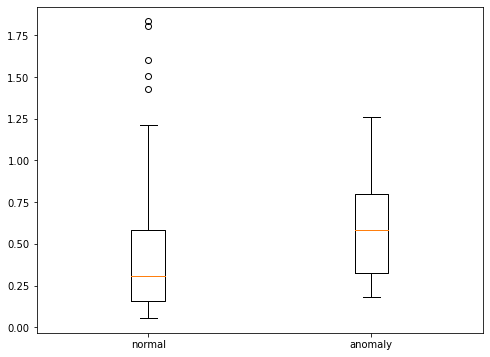

epoch [3/10], train loss:26.7837
epoch [4/10], train loss:22.1586
epoch [5/10], train loss:20.0154
epoch [6/10], train loss:18.9500
epoch [7/10], train loss:17.6740
epoch [8/10], train loss:16.9986
epoch [9/10], train loss:16.0784
epoch [10/10], train loss:15.0288


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,aggregate_MFCC,Autoencoder,0.826446,0.083333,0.090909,0.086957


<Figure size 432x288 with 0 Axes>

In [44]:
# MIMII_DUE Anomaly detection using Autoencoders (aggregate_MFCC)
mimii_AE_mfcc = autoencoder_test(
    X_train_mimii_mfcc,
    X_test_mimii_mfcc,
    X_val_mimii_mfcc,
    y_test_mimii_mfcc,
    y_val_mimii_mfcc,
    batch_size=16,
    lr=1e-3,
    epochs=10,
    extraction_type="aggregate_MFCC",
)
mimii_AE_mfcc

epoch [1/10], train loss:44.6493
epoch [2/10], train loss:16.3348


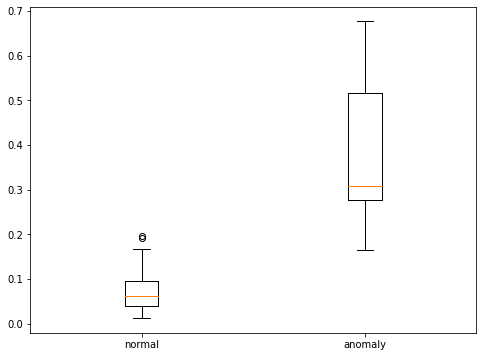

epoch [3/10], train loss:7.0146
epoch [4/10], train loss:4.5848
epoch [5/10], train loss:3.7160
epoch [6/10], train loss:3.2774
epoch [7/10], train loss:3.0065
epoch [8/10], train loss:2.8000
epoch [9/10], train loss:2.5758
epoch [10/10], train loss:2.4279


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,aggregate_MFCC,Autoencoder,0.969697,0.956522,0.814815,0.88


<Figure size 432x288 with 0 Axes>

In [45]:
# MIMII_DUE Anomaly detection using Autoencoders (aggregate_MFCC)
toy_AE_mfcc = autoencoder_test(
    X_train_toy_mfcc,
    X_test_toy_mfcc,
    X_val_toy_mfcc,
    y_test_toy_mfcc,
    y_val_toy_mfcc,
    batch_size=16,
    lr=1e-3,
    epochs=10,
    extraction_type="aggregate_MFCC",
)
toy_AE_mfcc

## AE_from_original_signal_amplitude_ts

epoch [1/10], train loss:8.0398
epoch [2/10], train loss:8.0386


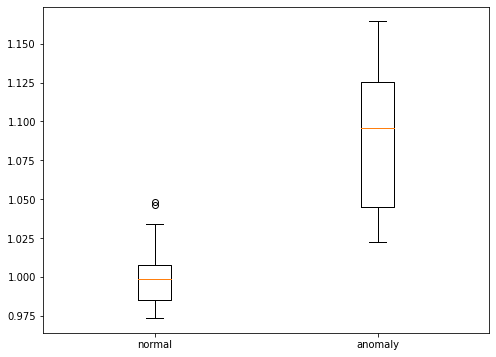

epoch [3/10], train loss:8.0102
epoch [4/10], train loss:8.0032
epoch [5/10], train loss:8.0057
epoch [6/10], train loss:8.0001
epoch [7/10], train loss:7.9989
epoch [8/10], train loss:7.9909
epoch [9/10], train loss:7.9664
epoch [10/10], train loss:7.9338


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,amplitude,Autoencoder,0.933884,0.714286,0.454545,0.555556


<Figure size 432x288 with 0 Axes>

In [46]:
# MIMII_DUE Anomaly detection using Autoencoders (original signal - amplitude ts)
mimii_AE_ts = autoencoder_test(
    X_train_mimii_ts,
    X_test_mimii_ts,
    X_val_mimii_ts,
    y_test_mimii_ts,
    y_val_mimii_ts,
    batch_size=128,
    lr=1e-3,
    epochs=10,
    extraction_type="amplitude",
)
mimii_AE_ts

epoch [1/10], train loss:13.0847
epoch [2/10], train loss:13.1938


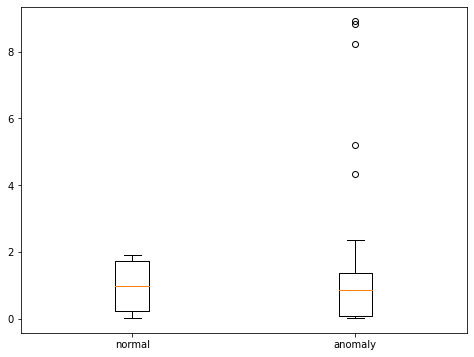

epoch [3/10], train loss:12.9063
epoch [4/10], train loss:12.6909
epoch [5/10], train loss:12.2276
epoch [6/10], train loss:12.0406
epoch [7/10], train loss:11.6243
epoch [8/10], train loss:11.5750
epoch [9/10], train loss:11.4953
epoch [10/10], train loss:11.3342


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,amplitude,Autoencoder,0.964646,0.916667,0.814815,0.862745


<Figure size 432x288 with 0 Axes>

In [47]:
# ToyAdmos Anomaly detection using Autoencoders (original signal - amplitude ts)
toy_AE_ts = autoencoder_test(
    X_train_toy_ts,
    X_test_toy_ts,
    X_val_toy_ts,
    y_test_toy_ts,
    y_val_toy_ts,
    batch_size=128,
    lr=1e-3,
    epochs=10,
    extraction_type="amplitude",
)
toy_AE_ts

## AE_from_melspectrogram

In [48]:
# MIMII_DUE Anomaly detection using Autoencoders (melspectrogram)
mimii_AE_mel = autoencoder_test(
    X_train_mimii_mel,
    X_test_mimii_mel,
    X_val_mimii_mel,
    y_test_mimii_mel,
    y_val_mimii_mel,
    batch_size=32,
    lr=1e-3,
    epochs=10,
    extraction_type="melspectrogram",
)
mimii_AE_mel

epoch [1/10], train loss:20281.1277
epoch [2/10], train loss:1128.6589
epoch [3/10], train loss:418.9223
epoch [4/10], train loss:393.4195
epoch [5/10], train loss:391.9324
epoch [6/10], train loss:391.8197
epoch [7/10], train loss:392.6080
epoch [8/10], train loss:394.8729
epoch [9/10], train loss:393.5829
epoch [10/10], train loss:392.1058


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,melspectrogram,Autoencoder,0.909091,0.0,0.0,0.0


In [49]:
# ToyAdmos Anomaly detection using Autoencoders (melspectrogram)
toy_AE_mel = autoencoder_test(
    X_train_toy_mel,
    X_test_toy_mel,
    X_val_toy_mel,
    y_test_toy_mel,
    y_val_toy_mel,
    batch_size=32,
    lr=1e-3,
    epochs=10,
    extraction_type="melspectrogram",
)
toy_AE_mel

epoch [1/10], train loss:126085.6419
epoch [2/10], train loss:9160.2036
epoch [3/10], train loss:7237.9713
epoch [4/10], train loss:3750.4600
epoch [5/10], train loss:1893.2355
epoch [6/10], train loss:1811.9961
epoch [7/10], train loss:1785.1871
epoch [8/10], train loss:1772.9046
epoch [9/10], train loss:1762.7888
epoch [10/10], train loss:1764.0715


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,melspectrogram,Autoencoder,0.949495,1.0,0.62963,0.772727
